In [22]:
import prophet
from prophet import Prophet

import pandas as pd
pd.set_option('precision', 2)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import optuna
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl

In [3]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]

## Load Data Using APIs

In [4]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-04-01,156.2,146.1,145.1,163.2,155.4,141.9,173.5,140.5,151.1
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4


# Prophet Model and Experiments

Though Prophet supports the incorporation of additional regressors, it does not explicitly support *lagged* regressors. That is, in order to produce forecasts that use additional regressors, the future value of those regressors must be known or assumed.

For example, if we add CAD-USD exchange rates as a regressor to the model, then we would need to supply future values of that regressor for as far into the future we are forecasting. Obviously we don't know what those future values will be, but perhaps in another experiment, we could assume those values. 

Another option would be to hack the model by lagging the regressors ourselves. We would do this by creating an additional regressor with a lag period equal to or grather than the forecast period of 18 months, the logic being that in 18 months, we will know what the value of any regressor was 18 months ago, or more than 18 months ago.

I don't like this approach as much (for linear models) because it introduces many more variables into the experiment: for any additional regressor, what are the optimal lags to use? And should we even use those variables in the first place? In any case, these are experiments that we could implement, as long as we are extremely consistent about forecast evaluation on our validation set. For now, let's just focus on the baseline autoregressive forecasts using Prophet, in its intended configuration.

## Data Splitting

Let's use an 80/20 split using the following dates. Training data range from January 1986 to June 2014 and validation data range from July 2014 to August 2021. In a sense, this is an extremely hard problem. We are training a model using historical data and evaluating it based on how accurately it generalizes to the COVID years - one of the most economically turbulent times in modern history.

I wonder: should we consider an 80/10/10 split instead? This would result in our test set ranging from early 2018 to August 2021. I suppose that when we are doing model selection, this most recent period is where we are most concerned with accuracy. And recall: evaluation on withheld data is for **model selection**. This experiment (to find models that generalize well from training to valid/test) will be used to inform which models/configurations we will use to produce the official forecast. We want to select the model/features/hyperparams that generalized well "in the past". Then we will take that model configuration, re-train it using the entire dataset (including the test set), and use it to produce a "candidate forecast". 

For each such candidate forecast, we should record any uncertainty/confidence metrics it provides, and evaluation metrics for that same model configuration over the test set. i.e. When model configuration XYZ was used to forecast Meat prices over the test set (with that data not being used for training or validation!) - what were its evaluation metrics on the withheld data? We should report this consistently for ALL EXPERIMENTS. 

In [88]:
train_dates = foodprice_df.index[:int(0.8*len(foodprice_df))]
train_dates

DatetimeIndex(['1986-01-01', '1986-02-01', '1986-03-01', '1986-04-01',
               '1986-05-01', '1986-06-01', '1986-07-01', '1986-08-01',
               '1986-09-01', '1986-10-01',
               ...
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01'],
              dtype='datetime64[ns]', name='REF_DATE', length=342, freq='MS')

In [89]:
valid_dates = foodprice_df.index[int(0.8*len(foodprice_df)):]
valid_dates

DatetimeIndex(['2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01',
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01',
               '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01',
               '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01',
               '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01',
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01',
      

In [90]:
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', food_category:'y'}, axis=1)
    return df

In [91]:
train_df = get_prophet_df(foodprice_df, 'Meat', train_dates)

In [92]:
model = Prophet()
model.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.06106
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1291.15    0.00733201       817.776           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1301.02   0.000203958       78.0338           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1304.73    0.00948437        583.53           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       1305.76   3.10667e-05       109.554   2.337e-07       0.001      484  LS failed, Hessian reset 
     399       1305.86   0.000469632       152.282           1           1      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     431       1306.77   8.42458e-05    

In [93]:
valid_df = get_prophet_df(foodprice_df, 'Meat', valid_dates)  # Actual values.
valid_forecast = model.predict(valid_df[['ds']])

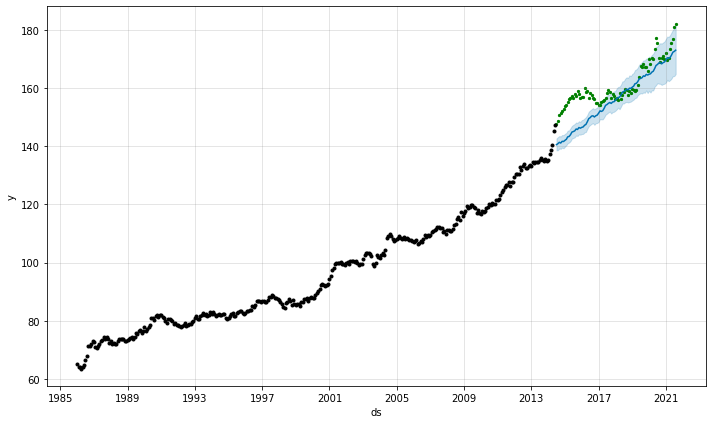

In [94]:
# valid_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig = model.plot(valid_forecast)
fig.axes[0].scatter(valid_df.ds, valid_df.y, color='green', s=5)
pass

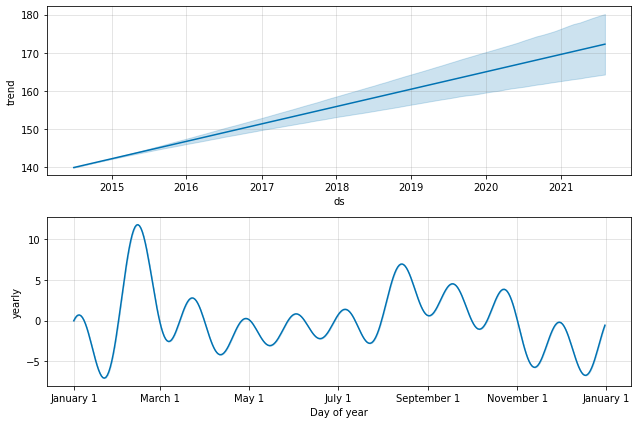

In [95]:
model.plot_components(valid_forecast)
pass

In [96]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

In [97]:
{metric_name: metric_fn(y_true=valid_df.y, y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

{'r2_score': 0.19758598629050506,
 'mae': 5.285579984374683,
 'mape': 0.03312675737294053,
 'mse': 45.265486193372325,
 'rmse': 6.727963004756516}